In [4]:
import sys
import scanpy as sc 
import random
import glob
import os
import scipy as sp
import csv

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from signaturescoring import score_signature
from signaturescoring.utils.utils import get_least_variable_genes_per_bin_v1

from scanpy.preprocessing._utils import _get_mean_var

sys.path.append('../..')
from data.load_data import load_datasets, load_dgex_genes_for_mal_cells

sc.settings.verbosity = 2

In [6]:
adata = load_datasets('crc')
if 'log1p' in adata.uns_keys():
    adata.uns['log1p']['base'] = None
else:
    adata.uns['log1p'] = {'base': None}

Load datasets with path /Users/lciernik/Documents/TUB/projects/ans_scoring/reproduce_project/data/preprocessed/pp_crc.h5ad


In [7]:
def get_bins_info(adata, nbins=25):
    X = adata.X
    df = pd.DataFrame()
    # compute mean and variance
    df['mean'], df['var'] = _get_mean_var(X)
    df = df.set_index(adata.var_names)
    df = df.sort_values(by='mean')
    
    gene_means = df['mean']
    
    ranked_gene_means = gene_means.rank(method="min")
    gene_bins = pd.cut(ranked_gene_means, 25, labels=False)
    
    bin_info =  pd.concat([
        gene_bins.value_counts().sort_index(),
        round(gene_bins.value_counts().sort_index() / len(gene_means) * 100, 2)
    ],axis=1)
    bin_info.columns = ['nr_genes', 'percent_tot_genes']
    
    
    return bin_info, gene_means, gene_bins

In [8]:
bin_info, gene_means, gene_bins = get_bins_info(adata)
bin_info

,nr_genes,percent_tot_genes
0,501,4.00
1,501,4.00
2,500,3.99
3,501,4.00
4,501,4.00
5,500,3.99
6,501,4.00
7,500,3.99
8,501,4.00
9,501,4.00


In [9]:
least_variable_genes_per_bin = get_least_variable_genes_per_bin_v1(adata, gene_bins, 100, method='seurat')

extracting highly variable genes
    finished (0:00:05)


In [10]:
least_variable_genes_per_bin

{0: ['VWA2',
  'LRRC8E',
  'SLC35D3',
  'CYP4F11',
  'SSTR1',
  'GJB5',
  'SHROOM2',
  'LYPD6',
  'DAGLA',
  'PLCH1',
  'MKRN2OS',
  'HTR1D',
  'GPR39',
  'RASSF10',
  'GPR143',
  'PLA2G12B',
  'POU5F1B',
  'B4GALNT4',
  'DSC3',
  'SLC6A7',
  'FUT1',
  'UNC93A',
  'CCDC113',
  'SIM2',
  'LRRC73',
  'RCOR2',
  'DMRT2',
  'TFAP2A-AS2',
  'FAM222A',
  'WASF3',
  'BCO1',
  'CYP4F2',
  'FREM1',
  'CFAP69',
  'SCML2',
  'HAS3',
  'SLC2A12',
  'GYG2',
  'PRR36',
  'SHANK2',
  'PLA2G4F',
  'PTPRU',
  'ISX',
  'LRRC31',
  'VANGL2',
  'HOXA6',
  'DCDC2',
  'MYOM3',
  'PCDHB9',
  'LINC00997',
  'ZIC2',
  'SPATA18',
  'KIAA0895',
  'PITPNM3',
  'MPP3',
  'GPRIN2',
  'SPTBN2',
  'CAPN9',
  'ZNF695',
  'GAL3ST1',
  'FAM201A',
  'PROM2',
  'INPP5J',
  'C12orf56',
  'GRM8',
  'CELSR2',
  'ZSWIM5',
  'RNF223',
  'KIF26A',
  'HOXC6',
  'EDAR',
  'ASAP3',
  'FLRT3',
  'HOXC11',
  'PKP1',
  'GXYLT2',
  'FAM47E',
  'PAK6',
  'SLC25A27',
  'EDA',
  'NRXN3',
  'BEND3',
  'SLC13A3',
  'PRKAA2',
  'SRCIN1',
  

In [11]:
gene_bins_diff = gene_bins.diff(1)

In [12]:
bin_idx = np.where(gene_bins_diff == 1)[0]

In [13]:
bin_idx = np.append(bin_idx, len(gene_bins))
bin_idx

array([  501,  1002,  1502,  2003,  2504,  3004,  3505,  4005,  4506,
        5007,  5507,  6008,  6508,  7009,  7510,  8010,  8511,  9011,
        9512, 10013, 10513, 11014, 11514, 12015, 12516])

In [14]:
gene_means = gene_means.sort_values()

/var/folders/_b/04dk8b115h509q_pyr_p34780000gn/T/ipykernel_47390/1934758983.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,5))


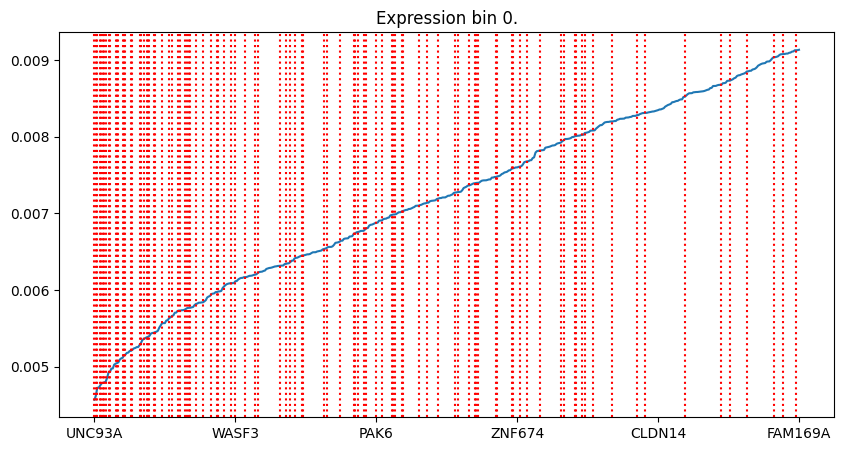

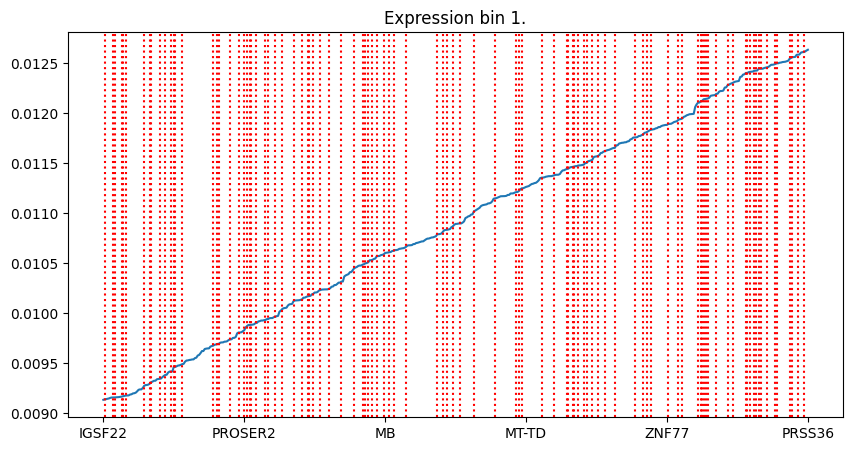

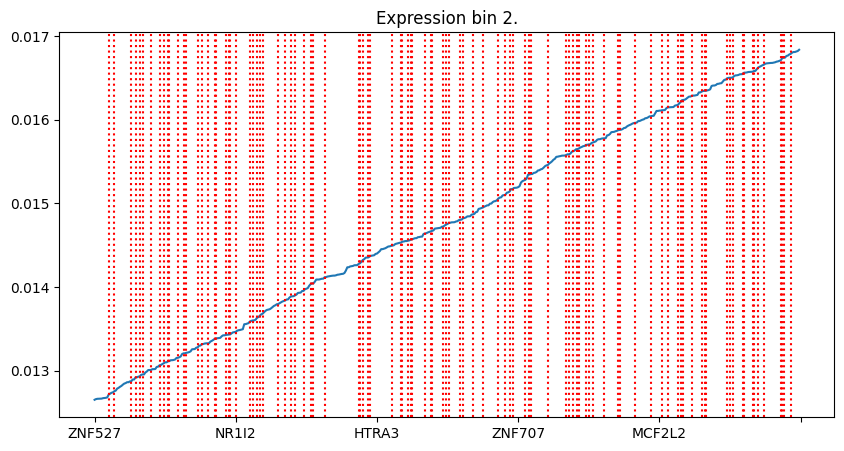

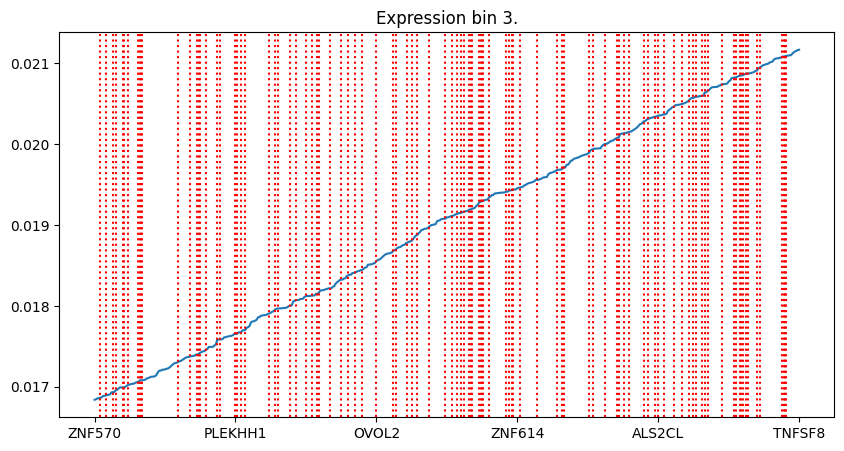

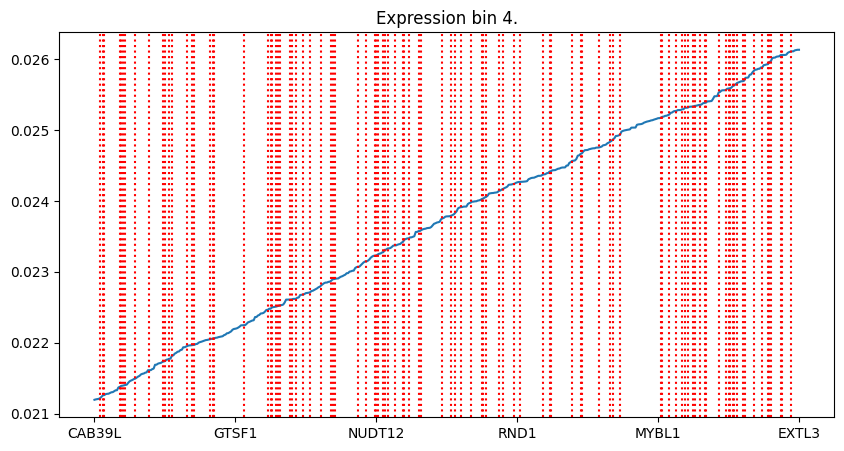

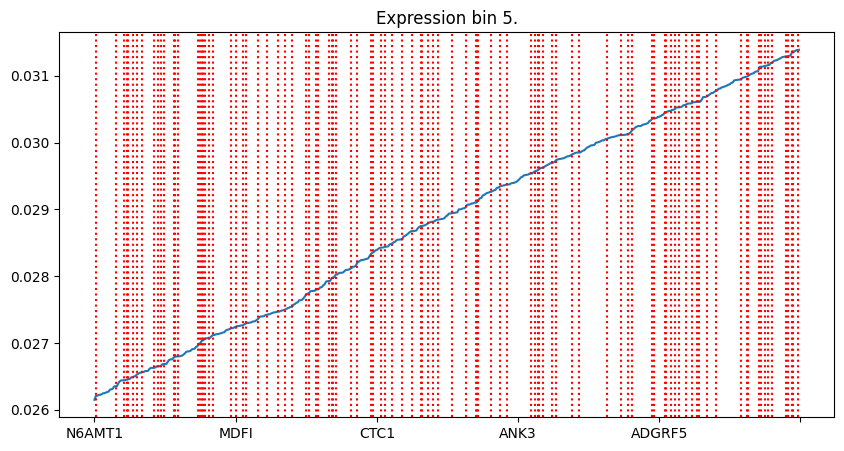

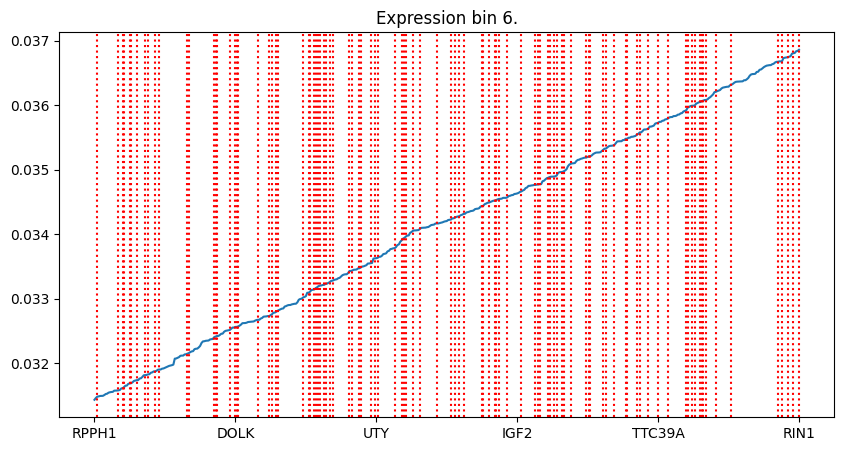

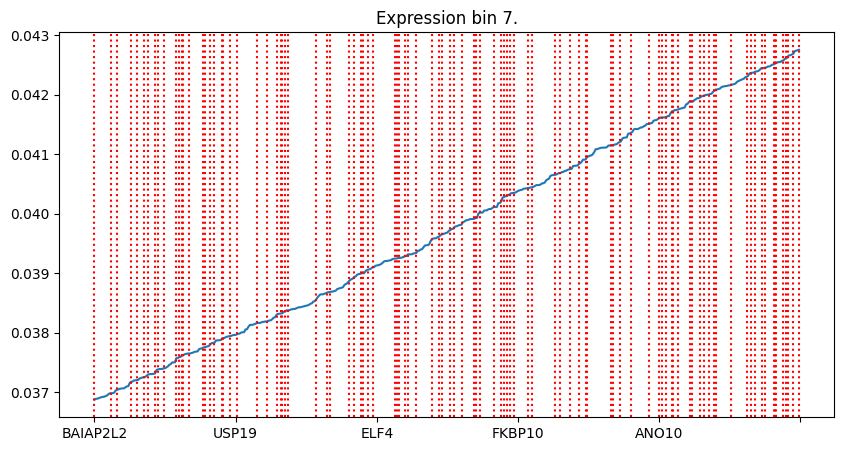

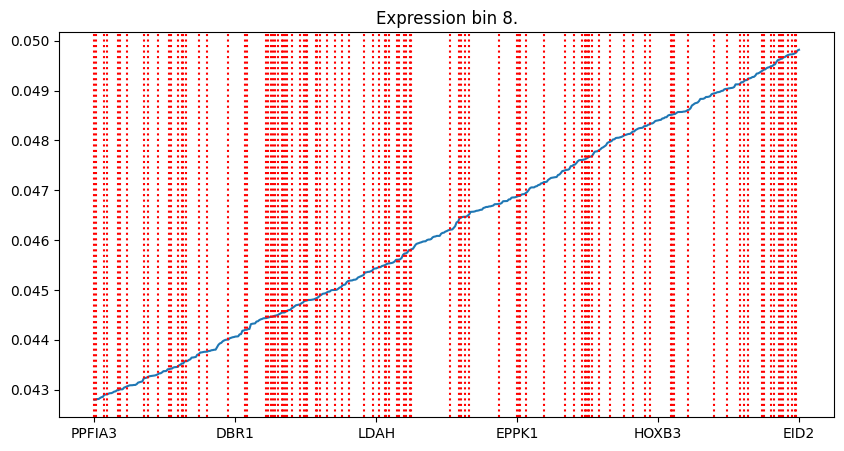

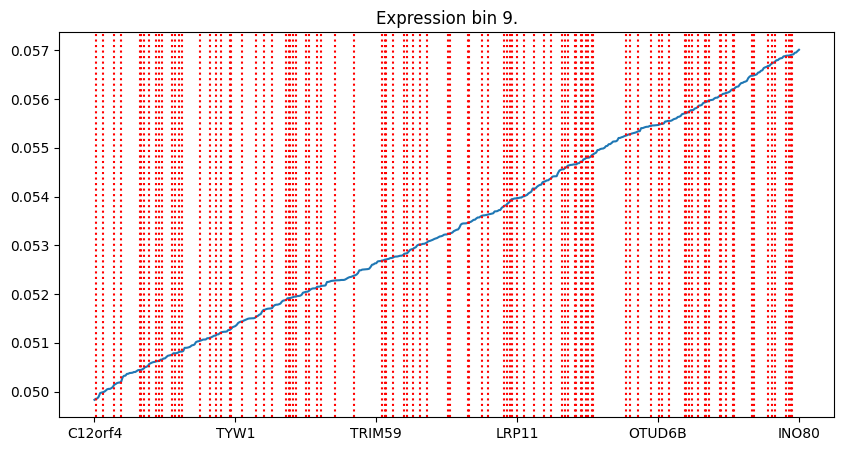

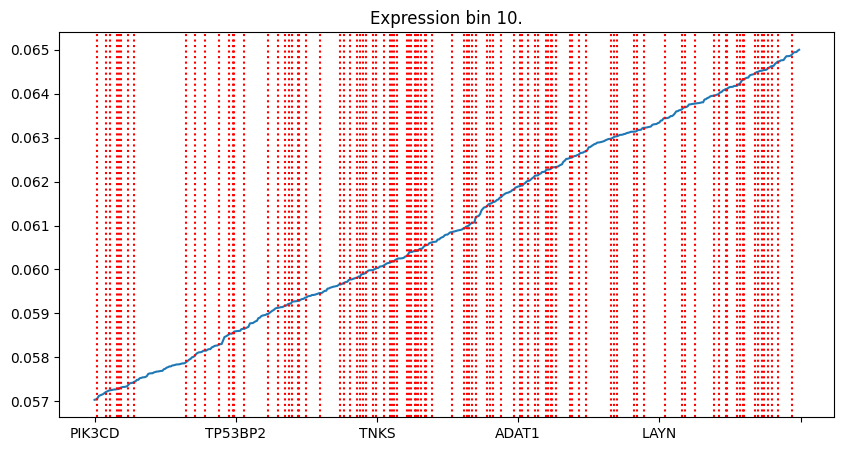

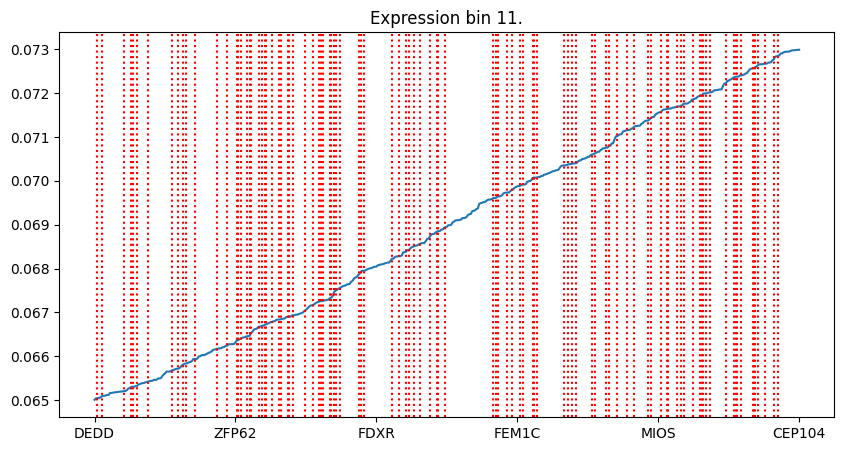

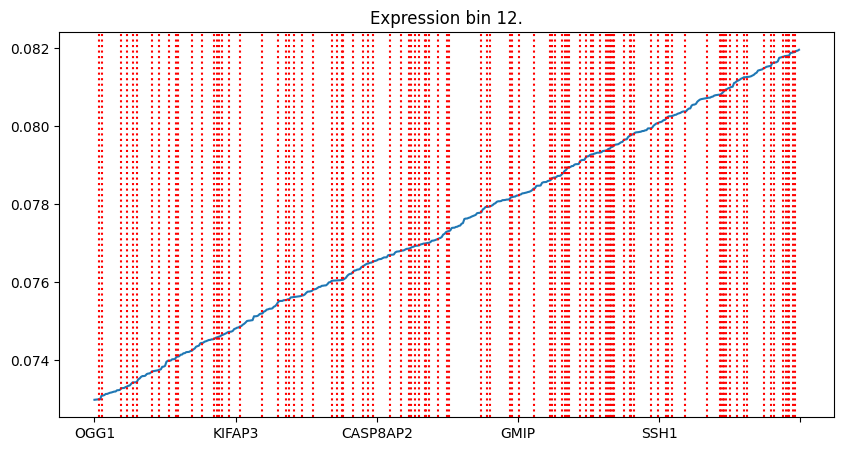

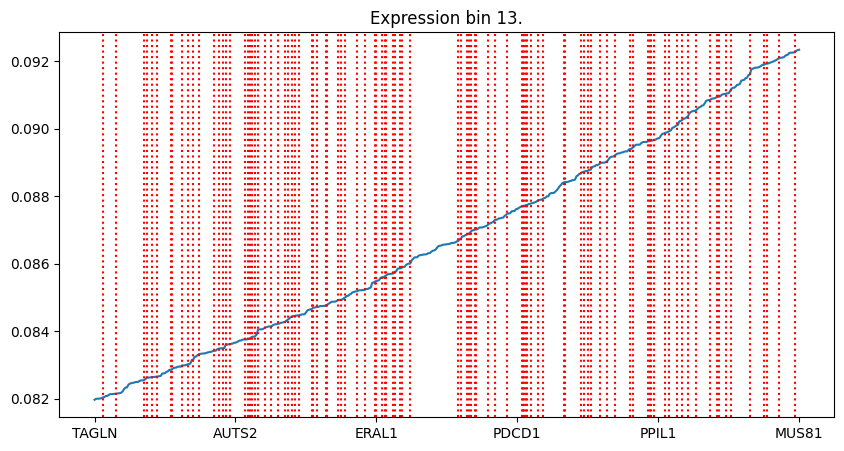

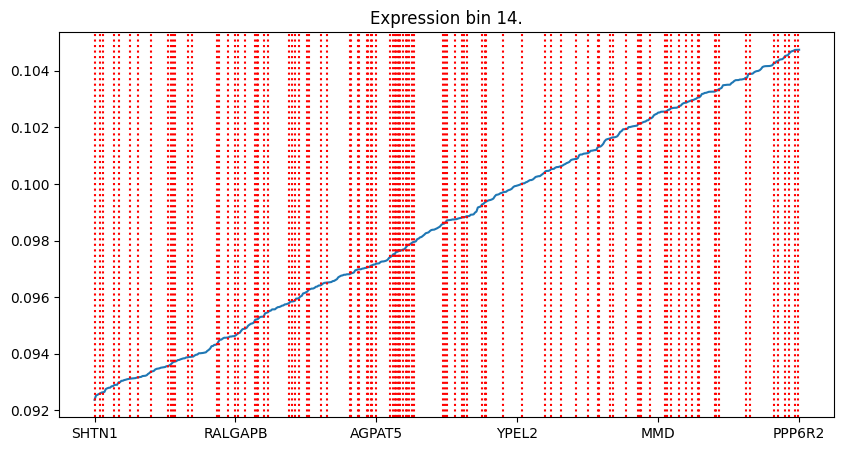

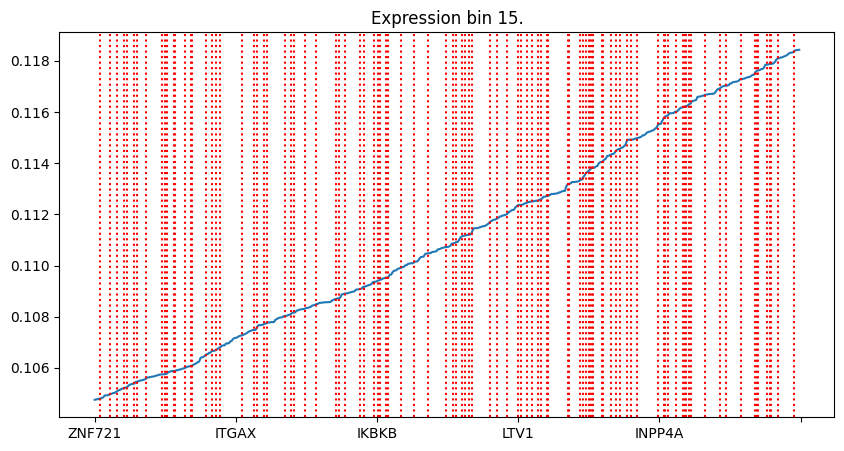

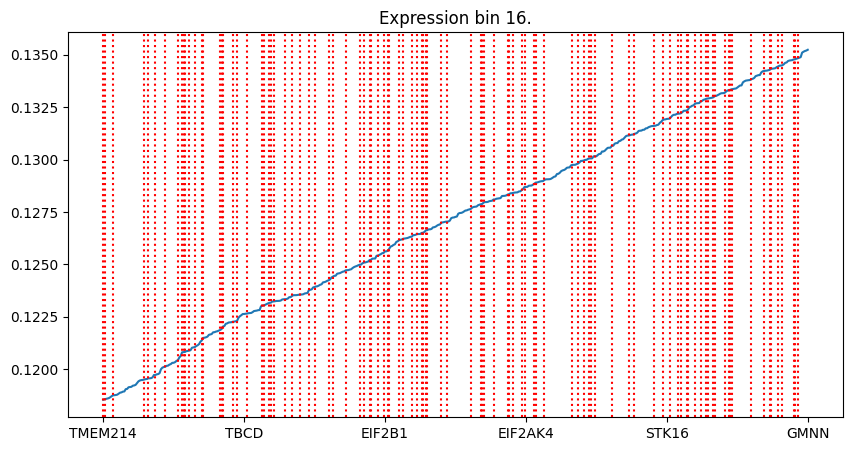

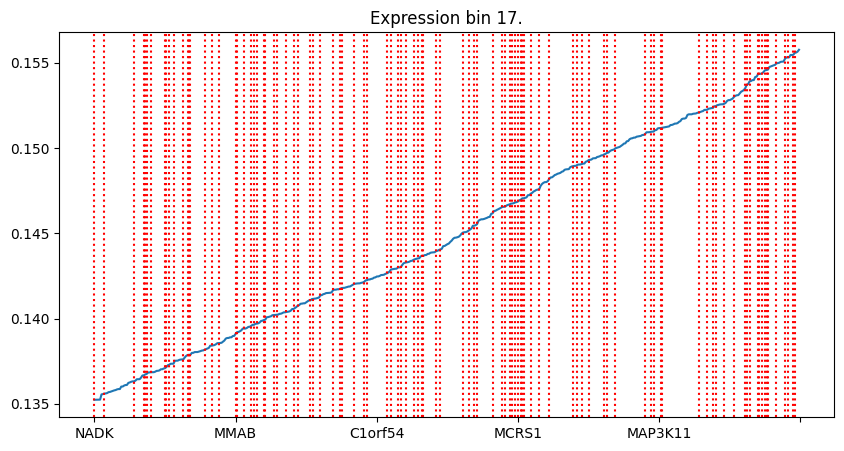

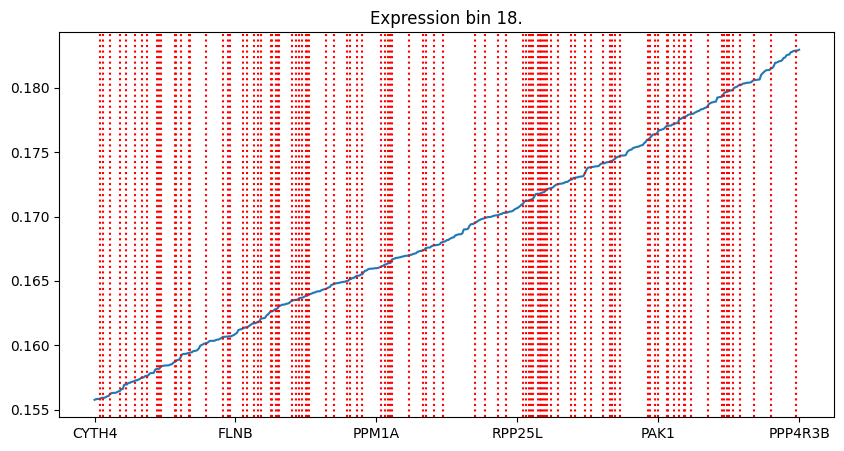

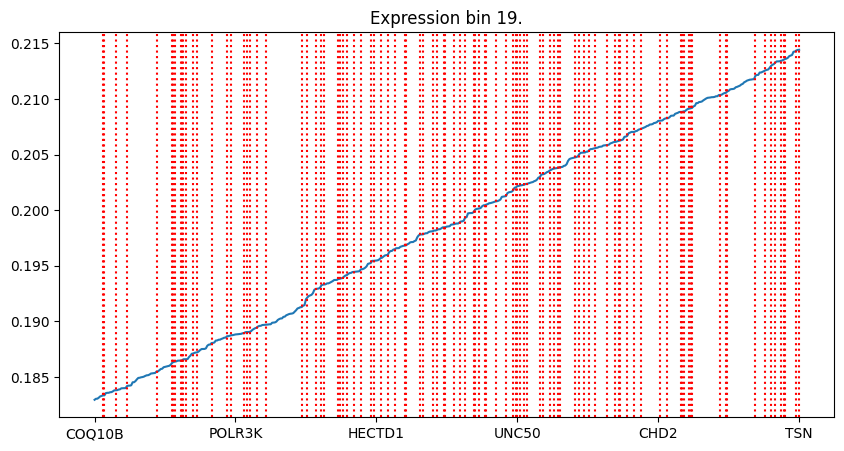

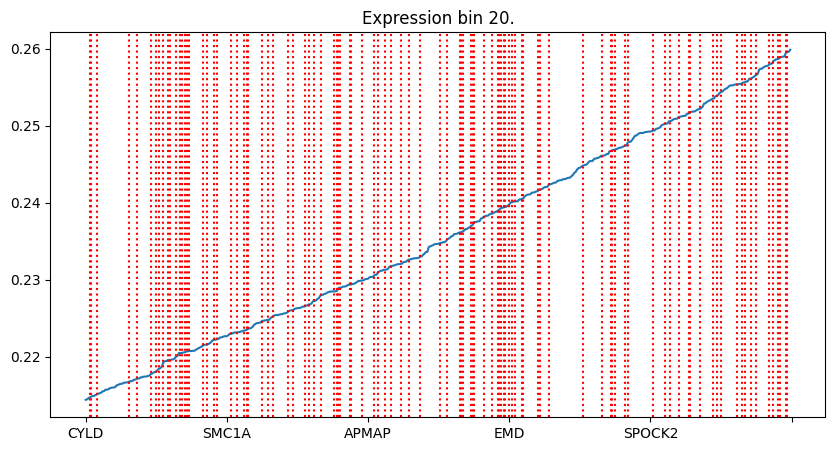

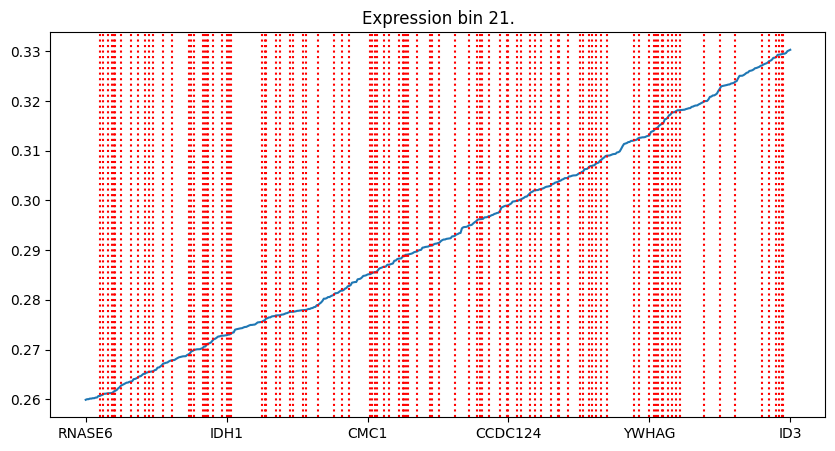

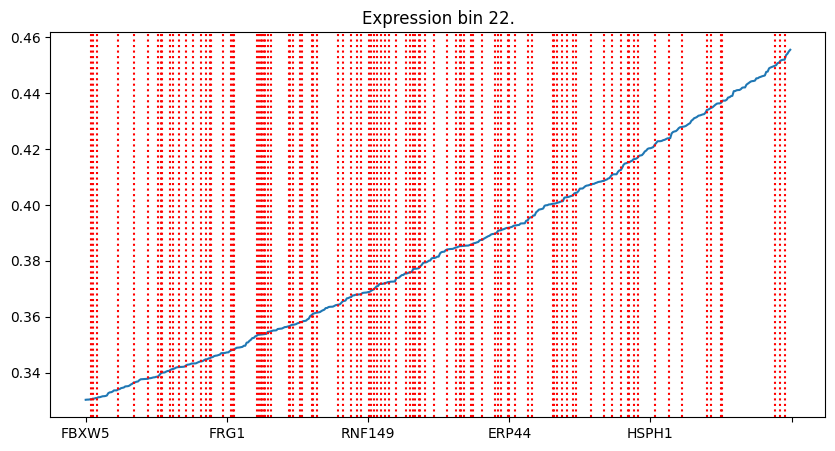

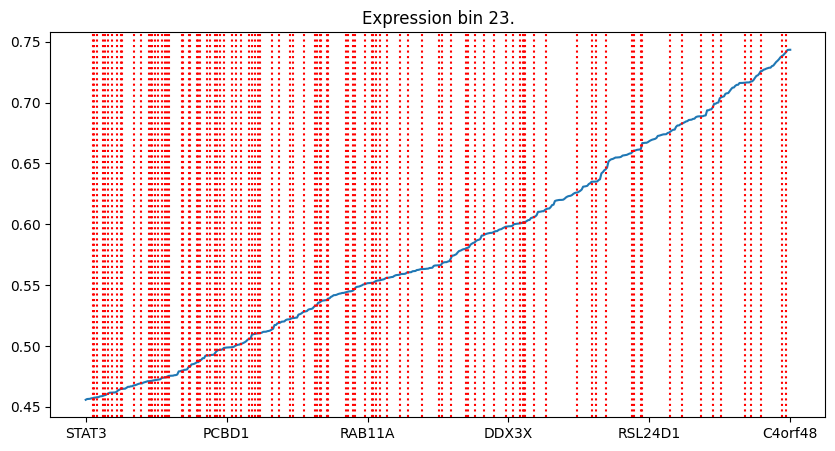

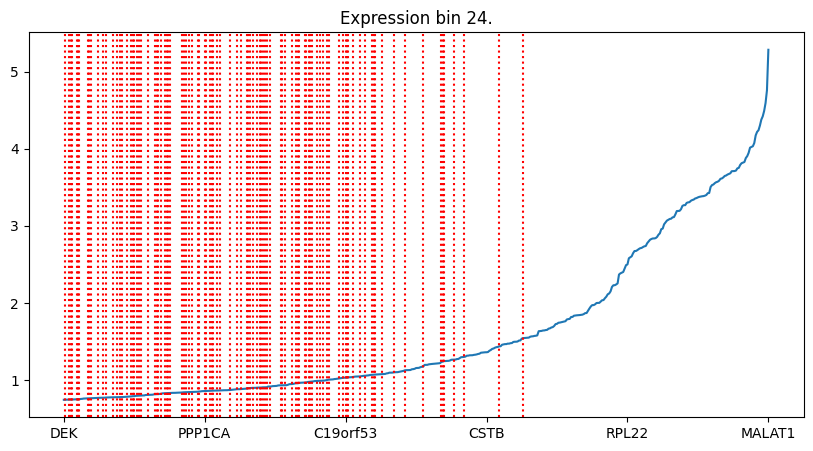

In [15]:
for i,(key, val) in enumerate(least_variable_genes_per_bin.items()):
    if i==0:
        curr_idx = 0
    else:
        curr_idx = bin_idx[i-1]
    next_idex = bin_idx[i]
    plt.figure(figsize=(10,5))
    tmp = gene_means.iloc[curr_idx:next_idex]
    tmp.plot()
    for y in val:
        plt.axvline(tmp.index.get_loc(y), c='r', ls=':')
    plt.title(f'Expression bin {key}.')